# Grounding

In order to provide truthful and transperent answers we may desire to:
* Filter specific pieces of  data used in generation
* Reference the sources of theses pieces of data
* Among filtered pieces of data, select exactly the facts lead the generation

The whole process is called grounding and is an advanced technique that will impact in RAGs performance and UX

Pros:
* Adds a reraking effect as relevant chunks are filtered
* Add a CoT effect as the LLM has to reason to find relevant pieces of data before generation
* Add transparency and build trust to the user

Cons
* Increased token consumption and latency
* Increased complexity of the RAG

![grounding](docs/grounding.png)




In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
from typing import List, TypedDict
from dotenv import load_dotenv

from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_qdrant import QdrantVectorStore
from langchain_core.prompts import ChatPromptTemplate

from src import utils, conf

c:\Users\manuelalberto.romero\Documents\repos\dslabs\dslab-rag-e2e\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [4]:
conf_settings = conf.load(file="settings.yaml")
conf_infra = conf.load(file="infra.yaml")    

LLM_WORKHORSE = conf_settings.llm_workhorse
LLM_FLAGSHIP = conf_settings.llm_flagship
EMBEDDINGS = conf_settings.embeddings
VDB_URL = conf_infra.vdb_url
INDEX_NAME = conf_settings.vdb_index


# Environment Variables

In [5]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

# Clients

In [6]:
llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    model=LLM_WORKHORSE,
    )
try:
    _ = llm.invoke("tell me a joke about devops")
except Exception as err:
    print(err)
    
embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY, model=EMBEDDINGS)
try:
    _ = embeddings.embed_query("healthcheck")

except Exception as err:
    print(err)



vector_store = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    collection_name=INDEX_NAME,
    url=VDB_URL,
    api_key=QDRANT_API_KEY,
)
try:
    _ = vector_store.asimilarity_search("healthcheck")
except Exception as err:
    print(err)


In [7]:
llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    model=LLM_WORKHORSE,
    )



# Context Example

In [16]:
doc1 = Document(
    page_content="""
## 1.1 Primeras observaciones y sospechas iniciales

El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas en órbita mutua y varios cuerpos orbitando de forma circumbinaria.
""",
    metadata={"source": "Divulgacion-Planetaria"}
)


doc2 = Document(
    page_content="""
Oumuamua se convirtió en 2017 en el primer objeto interestelar conocido que pasaba por el sistema solar. En un primer momento no mostró ninguna actividad cometaria, aunque, luego, analizando los cambios de su trayectoria, se comprobó que había expulsado algo de material. Pese a todo, la naturaleza de ‘Oumuamua ha sido motivo de controversia desde su descubrimiento. Lo más lógico es que los cuerpos interestelares como 1I/‘Oumuamua se hayan formado lejos del pozo gravitatorio de sus estrellas, lo que facilita que escapen al espacio interestelar.
""",
    metadata={"source": "Blog Naukas"}
)

doc3 = Document(
    page_content="""
No obstante, desde 2019 no habíamos vuelto a detectar ningún otro visitante interestelar y no teníamos más objetos que comparar. Afortunadamente, la espera ha terminado y ya conocemos un tercer objeto interestelar: 3I/ATLAS. Descubierto el 1 de julio por un telescopio robótico de la red ATLAS (Asteroid Terrestrial-impact Last Alert System) situado en Río Hurtado (Chile), se denominó originalmente A11pl3Z, siendo bautizado 3I/ATLAS o C/2025 N1 (ATLAS) hace tan solo dos días.
""",
    metadata={"source": "Blog Nukas"}
)

contexts = [doc3, doc2, doc1]




# Cite documents

In [17]:
from pydantic import BaseModel, Field




class CitedAnswer(BaseModel):
    """Responde la pregunta del usuario basado solo en el `contexto` dado y cita las fuentes empleadas en la respuesta"""

    answer: str = Field(
        ...,  # Field ellipsis (emphasizes that is required): https://docs.pydantic.dev/latest/concepts/fields/
        description="Respuesta concisa y veraz a la pregunta del usuario, basada solo en el `contexto` proporcionado.",
    )
    citations: List[int] = Field(
        ...,
        description="Los Id como enteros del `contexto` ESPECIFICO  empleado en la respuesta.",
    )

prompt_template = """Responde basandote unicamente en el `contexto` proporcionado a continuación :
```
{context}
```
pregunta: {question}
"""
prompt = ChatPromptTemplate.from_template(prompt_template)


llm_structured = llm.with_structured_output(CitedAnswer)




question= "El asteroide Ouamua puede venir del sistema Althera?"
chain_grounding = prompt | llm_structured
resp = chain_grounding.invoke({"question": question, "context": contexts})



In [18]:
type(resp)

__main__.CitedAnswer

In [19]:
resp.answer

'No se puede afirmar que el asteroide ‘Oumuamua provenga del sistema binario Althéra basándonos únicamente en el contexto proporcionado. Mientras que ‘Oumuamua es un objeto interestelar que ha pasado por el sistema solar, y Althéra es un sistema binario detectado en la constelación de Orión, no se menciona ninguna conexión directa entre ellos en el contexto dado.'

In [20]:
resp.citations

[1, 2]

In [14]:
question= "El asteroide Ouamua puede venir del sistema Althera?"

prompt_template_regular = """Answer the question based only on the following context:
```
{context}
```

Question: {question}
"""
prompt_regular = ChatPromptTemplate.from_template(prompt_template_regular)

chain_regular = prompt_regular | llm
resp_regular = chain_regular.invoke({"question": question, "context": contexts})


In [15]:
resp_regular.pretty_print()

================================== Ai Message ==================================

No, el asteroide ‘Oumuamua no puede venir del sistema Althéra según la información proporcionada. ‘Oumuamua fue identificado en 2017 como el primer objeto interestelar conocido que pasó por el sistema solar, mientras que el sistema binario Althéra fue detectado en el año 2032, es decir, después del paso de ‘Oumuamua. Además, no hay indicios en el texto que vinculen directamente a ‘Oumuamua con el sistema Althéra.


# Cite snippets

In [21]:
class Citation(BaseModel):
    """Cita que recoge la `fuente` y el literal (VERBATIM) sobre la que construye una respuesta"""
    source_id: int = Field(
        ...,
        description="Los Id como enteros del `contexto` ESPECIFICO  empleado en la respuesta.",
    )
    verbatim: str = Field(
        ...,
        description="La `cita` textual (VERBATIM) relevante de la fuente específica sobre la que se construye la respuesta, recogida de la manera lo más breve posible y ciñéndose a hechos muy concretos y altamente relevantes",
    )
    


class QuotedAnswer(BaseModel):
    """Responde la pregunta del usuario basado solo en el `contexto` dado y cita las fuentes empleadas en la respuesta"""

    answer: str = Field(
        ...,
        description="Respuesta concisa y veraz a la pregunta del usuario, basada solo en el `contexto` proporcionado y más concretamente en las `citas` relevantes identificadas",
    )
    citations: List[Citation] = Field(
        ..., description="Citation de los `contextos` sobre las que se apoya la respuesta, mencionando el Id de la fuente y VERBATIM"
    )


chain_grounding_quotes = prompt | llm.with_structured_output(QuotedAnswer)
resp = chain_grounding_quotes.invoke({"question": question, "context": contexts})

In [22]:
resp.answer

"No hay información en el contexto proporcionado que relacione directamente el asteroide interestelar 'Oumuamua con el sistema binario Althéra (HD 4579 AB), por lo que no se puede afirmar que 'Oumuamua provenga de ese sistema."

In [23]:
resp.citations

[Citation(source_id=2, verbatim='El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032... el análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas en órbita mutua y varios cuerpos orbitando de forma circumbinaria.'),
 Citation(source_id=1, verbatim='Oumuamua se convirtió en 2017 en el primer objeto interestelar conocido que pasaba por el sistema solar. En un primer momento no mostró ninguna actividad cometaria... Lo más lógico es que los cuerpos interestelares como 1I/‘Oumuamua se hayan formado lejos del pozo gravitatorio de sus estrellas, lo que facilita que escapen al espacio interestelar.')]

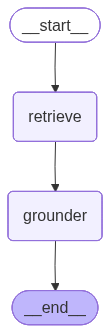

In [24]:
from langgraph.graph import START, StateGraph

class State(TypedDict):
    question: str
    context: List[Document]
    answer: QuotedAnswer

def format_docs(docs: List[Document]) -> str:
    lst_context = []


    for i, doc in enumerate(docs):

        assert isinstance(doc, Document)
        content = doc.page_content
        source = doc.metadata['source']
        lst_context.append(
            f"contexto {i}:\n{content}\nfuente: {source}"
        )
    return "\n\n".join(lst_context)

def retrieve(state: State):
    return {"context": contexts}

def grounder(state: State):

    docs_content = format_docs(state["context"])
    structured_llm = llm.with_structured_output(QuotedAnswer)

    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = structured_llm.invoke(messages)  # QuotedAnswer
    return {"answer": response}

g = StateGraph(State).add_sequence([retrieve, grounder])
g.add_edge(START, "retrieve")
rag = g.compile()
rag


In [25]:
resp = rag.invoke({"question": question})

resp

{'question': 'El asteroide Ouamua puede venir del sistema Althera?',
 'context': [Document(metadata={'source': 'Blog Nukas'}, page_content='\nNo obstante, desde 2019 no habíamos vuelto a detectar ningún otro visitante interestelar y no teníamos más objetos que comparar. Afortunadamente, la espera ha terminado y ya conocemos un tercer objeto interestelar: 3I/ATLAS. Descubierto el 1 de julio por un telescopio robótico de la red ATLAS (Asteroid Terrestrial-impact Last Alert System) situado en Río Hurtado (Chile), se denominó originalmente A11pl3Z, siendo bautizado 3I/ATLAS o C/2025 N1 (ATLAS) hace tan solo dos días.\n'),
  Document(metadata={'source': 'Blog Naukas'}, page_content='\nOumuamua se convirtió en 2017 en el primer objeto interestelar conocido que pasaba por el sistema solar. En un primer momento no mostró ninguna actividad cometaria, aunque, luego, analizando los cambios de su trayectoria, se comprobó que había expulsado algo de material. Pese a todo, la naturaleza de ‘Oumuamua

In [26]:
print(f"Answer: {resp['answer'].answer}")

for cite in resp['answer'].citations:
    source_id = cite.source_id
    source_name = resp['context'][source_id].metadata['source']
    print("-"*30)
    print(f"source: {source_name}")
    print(f"cite: {cite.verbatim}")

Answer: No hay información en el contexto proporcionado que indique que el objeto interestelar 'Oumuamua provenga del sistema Althéra. 'Oumuamua es descrito como un objeto interestelar que pasó por nuestro sistema solar y que probablemente se formó lejos del pozo gravitatorio de su estrella de origen, facilitando su escape al espacio interestelar, pero no se menciona ninguna conexión con el sistema Althéra.
------------------------------
source: Blog Naukas
cite: Oumuamua se convirti  en 2017 en el primer objeto interestelar conocido que pasaba por el sistema solar. En un primer momento no mostr  ninguna actividad cometaria, aunque, luego, analizando los cambios de su trayectoria, se comprob  que hab  expulsado algo de material. Pese a todo, la naturaleza de  9Oumuamua ha sido motivo de controversia desde su descubrimiento. Lo m s l gico es que los cuerpos interestelares como 1I/ 9Oumuamua se hayan formado lejos del pozo gravitatorio de sus estrellas, lo que facilita que escapen al esp